In [1]:
# Libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.animation as animation
from tqdm import tqdm

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

In [2]:
# Network Style
network_topology = "cubic"

# Network Parameter
# topology_parameter  = {
#     "Np"    : 25,
#     "Nj"    : 4,
#     "e_pos" : [[-1,-1],[1,1]]
# }
topology_parameter  = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[3,0,0],[0,3,0],[6,0,0],[0,6,0],[6,3,0],[3,6,0],[6,6,0]]
}

# Save Folder
folder  = "test_runs/"

# Topology Class
np_network_sim = nanonets.simulation(network_topology=network_topology, folder=folder, topology_parameter=topology_parameter)

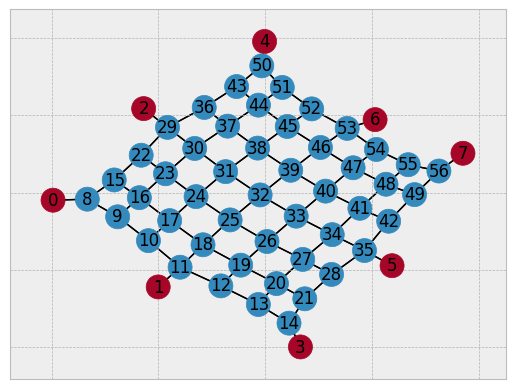

In [9]:
# Return Graph Object
G   = np_network_sim.return_graph_object()

# Node Colors
colors                                  = np.repeat('#348ABD', np_network_sim.N_particles+np_network_sim.N_electrodes)
colors[:np_network_sim.N_electrodes]    = '#A60628'

# Display Graph
with plt.style.context(["bmh"]):

    fig = plt.figure()
    ax  = fig.add_subplot()
    nx.draw_networkx(G=G,  ax=ax, node_color=colors, arrows=False)
    plt.show()

#### Input Voltage

Number of Steps: 50000


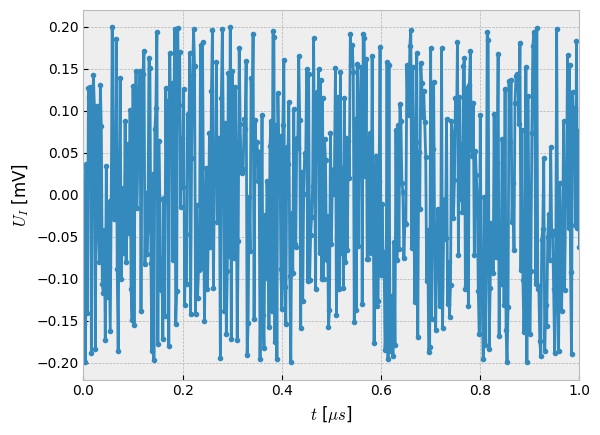

In [83]:
# Define Time Scale
step_size   = 2e-9
max_time    = 1e-4
time_steps  = np.arange(0,max_time,step_size)
N_steps     = len(time_steps)

print(f"Number of Steps: {N_steps}")

input_volt = np.random.uniform(-0.2,0.2,N_steps)

# Voltage Array
N_electrodes    = np_network_sim.N_electrodes
voltages        = np.zeros((N_steps, N_electrodes+1))
voltages        = np.zeros((N_steps, N_electrodes+1))
voltages[:,0]   = input_volt

# Plot
with plt.style.context("bmh"):
    
    plt.plot(time_steps*10**6, input_volt, '.-')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$U_I$ [mV]")
    plt.xlim(0,1)
    plt.show()

In [180]:
def train_test_split(voltages, pred_d=1, train_S=5000, test_S=5000, offset=100):

    offset  = 100
    train_S = 5000
    test_S  = 5000
    u_train = voltages[offset:(train_S+offset)]
    y_train = voltages[(offset-pred_d):(train_S+offset-pred_d)]

    u_test  = voltages[(train_S+offset):(train_S+offset+test_S)]
    y_test  = voltages[(train_S+offset-pred_d):(train_S+offset+test_S-pred_d)]

    t_train = time_steps[offset:(train_S+offset)]
    t_test  = time_steps[(train_S+offset):(train_S+offset+test_S)]

    return t_train, u_train, y_train, t_test, u_test, y_test

def run_simulation(voltages, time_steps, target_electrode, network_topology, topology_parameter, R, Rstd, store_per_it_min=0, store_per_it_max=0, folder="", n_stat=20, save_th=.1, start_val=100):

    output_vals     = []
    microstate      = []
    landscape       = []
    net_currents    = []
    network_classes = []
    
    for _ in tqdm(range(n_stat)):
    
        np_network_sim = nanonets.simulation(network_topology=network_topology, folder=folder, topology_parameter=topology_parameter)
        np_network_sim.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=target_electrode, save_th=save_th,
                                        store_per_it_min=store_per_it_min, store_per_it_max=store_per_it_max, R=R, Rstd=Rstd)
        
        # Return Output Current
        output_df               = pd.DataFrame(np_network_sim.return_output_values()).iloc[start_val:,1:3].reset_index(drop=True)
        output_df.columns       = ["Jumps","Current"]
        output_df["Current"]    = output_df["Current"]/1000

        # Return Microstate
        microstate_df   = pd.DataFrame(np_network_sim.return_microstates()).iloc[start_val:,:].reset_index(drop=True)

        # Return Landscape
        landscape_df    = pd.DataFrame(np_network_sim.return_potential_landscape()).iloc[start_val:,np_network_sim.N_electrodes:].reset_index(drop=True)

        # Return Network Currents
        jump_paths, network_I   = np_network_sim.return_network_currents()
        network_I_df            = pd.DataFrame(network_I)
        network_I_df.columns    = jump_paths
        network_I_df            = network_I_df.iloc[start_val:].reset_index(drop=True)

        # Append Results
        output_vals.append(output_df)
        microstate.append(microstate_df)
        landscape.append(landscape_df)
        net_currents.append(network_I_df)
        network_classes.append(np_network_sim)

    outputs = {
        "output"            : output_vals,
        "microstate"        : microstate,
        "landscape"         : landscape,
        "net_currents"      : net_currents,
        "network_classes"   : network_classes
    }

    return outputs

def result_statistics(t_arr, u_arr, simulation_outputs, n_stat=20, euilibrium_steps=100):

    dfs = []

    for _ in range(n_stat):
        
        df_tmp      = pd.DataFrame()
        df_tmp['t'] = t_arr[euilibrium_steps+1:]
        df_tmp['U'] = u_arr[euilibrium_steps+1:,0]
        df_currs    = simulation_outputs['net_currents'][0]
        cols        = df_currs.columns

        for i in range(N_electrodes):

            for col in cols:
                if col[0] == i:
                    a = df_currs[col]
                if col[1] == i:
                    b = df_currs[col]
            
            diff            = b - a
            df_tmp[f'I{i}'] = diff
        dfs.append(df_tmp)

    in_out          = pd.DataFrame(np.mean(dfs,axis=0))
    in_out_error    = pd.DataFrame(np.std(dfs,axis=0))/np.sqrt(n_stat)

    in_out.columns          = df_tmp.columns
    in_out_error.columns    = df_tmp.columns

    return in_out, in_out_error

def fit_data(in_out, yvals, regularization_coeff = 1e-8):

    X       = in_out.loc[:,'I1':].T.values
    y       = yvals[1:,0].copy()
    W_out   = np.linalg.solve(np.dot(X,X.T) + regularization_coeff*np.eye(X.shape[0]), np.dot(X,y.T)).T

    return W_out

def predict(in_out, W_out):

    y_pred  = []
    arr     = in_out.loc[:,'I1':].values

    for val in arr:

        y_val   = np.dot(W_out,val[:,np.newaxis])[0]
        y_pred.append(y_val)

    return np.array(y_pred)

In [102]:
t_train, u_train, y_train, t_test, u_test, y_test = train_test_split(voltages)

In [104]:
train_output  = run_simulation(voltages=u_train, time_steps=t_train, target_electrode=N_electrodes-1,
                network_topology=network_topology, topology_parameter=topology_parameter,
                R=25.0, Rstd=0.0,start_val=0)

test_output   = run_simulation(voltages=u_test, time_steps=t_train, target_electrode=N_electrodes-1,
                network_topology=network_topology, topology_parameter=topology_parameter,
                R=25.0, Rstd=0.0,start_val=0)

100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


In [109]:
in_out_train, in_out_train_error    = result_statistics(t_train, u_train, train_output, euilibrium_steps=0)
in_out_test, in_out_test_error      = result_statistics(t_test, u_test, test_output, euilibrium_steps=0)

In [112]:
W_out = fit_data(in_out_train, y_train)

In [139]:
y_pred = predict(in_out_test,W_out)

In [206]:
predictions = []
test_values = []

for pred_d in np.arange(1,21,1):

    t_train, u_train, y_train, t_test, u_test, y_test = train_test_split(voltages,pred_d=pred_d)

    train_output  = run_simulation(voltages=u_train, time_steps=t_train, target_electrode=N_electrodes-1,
                    network_topology=network_topology, topology_parameter=topology_parameter,
                    R=25.0, Rstd=0.0, start_val=0, n_stat=1)

    test_output   = run_simulation(voltages=u_test, time_steps=t_train, target_electrode=N_electrodes-1,
                    network_topology=network_topology, topology_parameter=topology_parameter,
                    R=25.0, Rstd=0.0, start_val=0, n_stat=1)
    
    in_out_train, in_out_train_error    = result_statistics(t_train, u_train, train_output, euilibrium_steps=0, n_stat=1)
    in_out_test, in_out_test_error      = result_statistics(t_test, u_test, test_output, euilibrium_steps=0, n_stat=1)
    
    W_out   = fit_data(in_out_train, y_train)
    y_pred  = predict(in_out_test,W_out)

    predictions.append(y_pred)
    test_values.append(y_test)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


In [185]:
corr_coeffs = []

for i, y_pred in enumerate(predictions):

    corr_coeffs.append(np.corrcoef(y_pred,test_values[i][1:,0])[0,1])

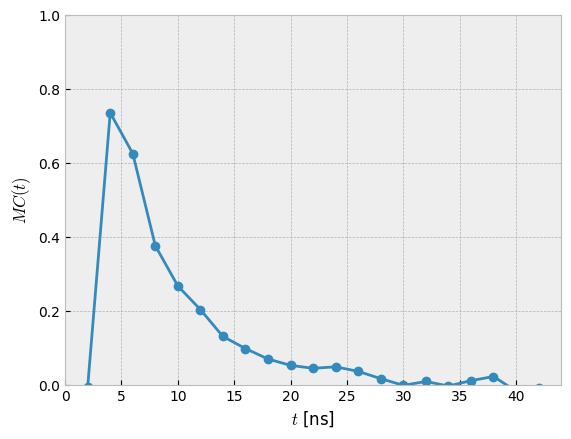

In [207]:
with plt.style.context("bmh"):
    plt.figure()
    plt.plot(np.cumsum(np.repeat(step_size,len(corr_coeffs)))*10**9, corr_coeffs, '-o')
    plt.xlabel("$t$ [ns]")
    plt.ylabel("$MC(t)$")
    plt.ylim(0,1)
    plt.show()